In [2]:
from importlib import reload
from src import parsing
from src import model_path
from src import models_path
from src import model_goal
from src import models_goal
from src import model_interface
from src import visualization
from src import util
from src import config
reload(parsing)
reload(model_path)
reload(models_path)
reload(model_goal)
reload(models_goal)
reload(model_interface)
reload(visualization)
reload(util)
reload(config)

import numpy as np
import matplotlib.pyplot as plt
import seaborn
import random
import statistics

In [3]:
# load input
# since we use a different file then for training we can use everything for eval
file_path = "medium_ab.csv"
_, eval_data, _ = parsing.parse_atc_day(file_path, train_ratio=0.02, eval_ratio=0.98)

100%|██████████| 1058/1058 [00:05<00:00, 201.46it/s]


1058 unique ids found. Generated 37667 sequences total from 549 trajectories.
Skipped 457 trajectories.
        307 too short
        150 frequency issues (like gaps)
    
Skipped 17 sequences (0.045%) because of abnormally high absolute value after normalization
Dividing 549 human trajectories: 10 training, 539 eval, 0 test
train (466, 50, 2) float32 (466, 25) float32 (466, 50, 2) float32
eval (37201, 50, 2) float32 (37201, 25) float32 (37201, 50, 2) float32


28758


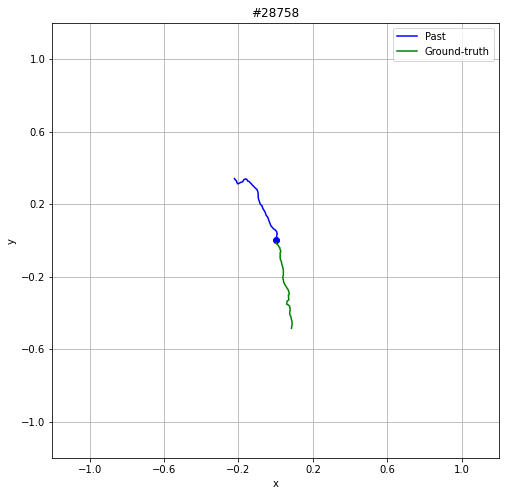

In [5]:
# select random sample
N = random.randint(0, eval_data[0].shape[0])
input_path = eval_data[0][N]
output_path = eval_data[2][N]
goals = eval_data[1][N]
print(N)

visualization.draw_path(x=input_path, ground_truth=output_path, name=f"#{N}")

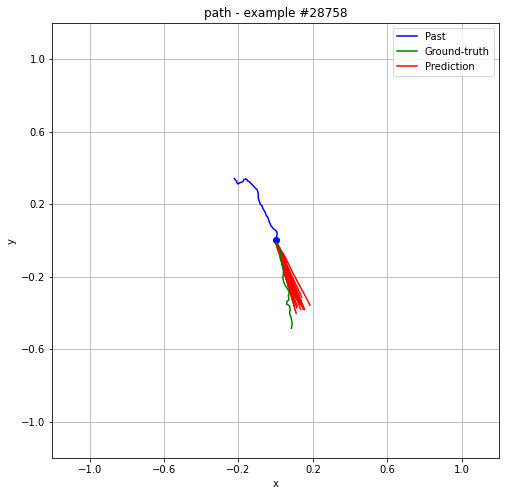

0.05462145359197166


In [26]:
## CNN model
reload(util)
# load trained model
m = model_path.ModelPath(uses_goal=False)
m.load('path_cnn_droput_a')


visualization.draw_path_batch(x=eval_data[0], ground_truth=eval_data[2], prediction_model=m, samples=20, skip=N)
mMDE_cnn, mFDE_cnn = m.metrics_probabilistic(input_path, output_path, samples=5)

samples_cnn = m.prediction_sampling(x=input_path, samples=5)
uncertainty_cnn = util.epistemic_uncertainty_path(samples_cnn)
print(mMDE_cnn)

In [27]:
print(mMDE_cnn)

0.09739743386395276


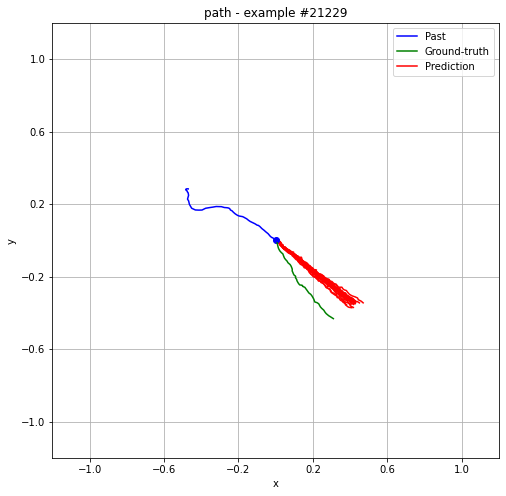

In [48]:
## TF model
# load trained model
m = model_path.ModelPath(uses_goal=False)
m.load('path_transformerk_dropout_a')


visualization.draw_path_batch(x=eval_data[0], ground_truth=eval_data[2], prediction_model=m, samples=20, skip=N, conflux_strength=2.5, cs=100)
mMDE_cnn, mFDE_cnn = m.metrics_probabilistic(input_path, output_path, samples=100)

samples_tf = m.prediction_sampling(x=input_path)
uncertainty_tf = util.epistemic_uncertainty_path(samples_tf)

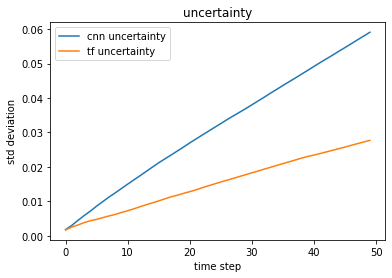

In [45]:
fig, ax = plt.subplots()
plt.title('uncertainty')
plt.xlabel('time step')
plt.ylabel('std deviation')
plt.plot(uncertainty_cnn, label='cnn uncertainty')
plt.plot(uncertainty_tf, label='tf uncertainty')
ax.legend()
plt.show()
m = None

20 <class 'list'> (50, 2)
1: 0.0000022 0.0000014, 0.0000008
2: 0.0000067 0.0000045, 0.0000021
3: 0.0000142 0.0000094, 0.0000048
4: 0.0000249 0.0000151, 0.0000098
5: 0.0000375 0.0000235, 0.0000140
6: 0.0000539 0.0000332, 0.0000207
7: 0.0000749 0.0000457, 0.0000292
8: 0.0000983 0.0000607, 0.0000375
9: 0.0001239 0.0000764, 0.0000475
10: 0.0001500 0.0000938, 0.0000563
11: 0.0001802 0.0001144, 0.0000658
12: 0.0002136 0.0001364, 0.0000772
13: 0.0002458 0.0001563, 0.0000895
14: 0.0002815 0.0001783, 0.0001032
15: 0.0003143 0.0001994, 0.0001149
16: 0.0003544 0.0002245, 0.0001299
17: 0.0003933 0.0002496, 0.0001437
18: 0.0004341 0.0002726, 0.0001615
19: 0.0004800 0.0003009, 0.0001791
20: 0.0005253 0.0003292, 0.0001961
21: 0.0005773 0.0003634, 0.0002139
22: 0.0006243 0.0003926, 0.0002317
23: 0.0006759 0.0004252, 0.0002507
24: 0.0007300 0.0004594, 0.0002705
25: 0.0007888 0.0004964, 0.0002923
26: 0.0008453 0.0005317, 0.0003135
27: 0.0009094 0.0005756, 0.0003338
28: 0.0009755 0.0006158, 0.0003597
29:

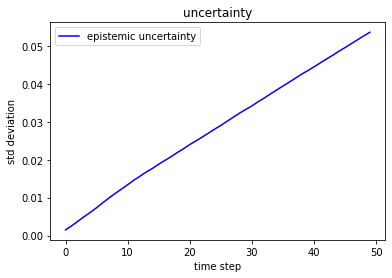

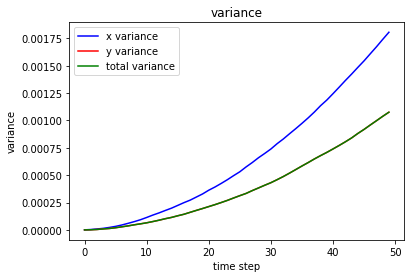

In [34]:
predictions = predictions_cnn
print(len(predictions), type(predictions), predictions[0].shape)

# convert list into single numpy matrix: (sample, time_step, x/y)
unified = np.array(predictions)
output_time_steps = unified.shape[1]

arr_x_var = []
arr_y_var = []
arr_total_var = []
for time_step in range(output_time_steps):
    # calculate variances for x and y for every time step
    x_var = unified[:, time_step, 0].var()
    y_var = unified[:, time_step, 1].var()

    # since x and y are independent random variables, just sum them to get the total, for this time-step
    total_var = x_var + y_var

    arr_x_var.append(x_var)
    arr_y_var.append(y_var)
    arr_total_var.append(total_var)

    print(f"{time_step+1}: {total_var:.7f} {x_var:.7f}, {y_var:.7f}")

arr_total_std = np.sqrt(arr_total_var)
print(arr_total_std)

# std
fig, ax = plt.subplots()
plt.title('uncertainty')
plt.xlabel('time step')
plt.ylabel('std deviation')
plt.plot(arr_total_std, 'b', label='epistemic uncertainty')
ax.legend()
plt.show()

# variances
fig, ax = plt.subplots()
plt.title('variance')
plt.xlabel('time step')
plt.ylabel('variance')
plt.plot(arr_x_var, 'b', label='x variance')
plt.plot(arr_y_var, 'r', label='y variance')
plt.plot(arr_y_var, 'g', label='total variance')
ax.legend()
plt.show()

(1000,) (1000,)


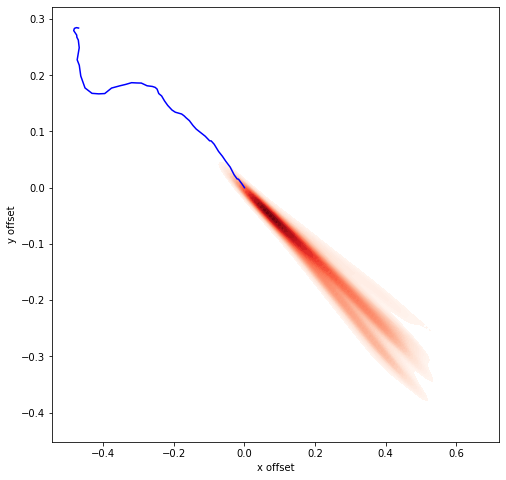

In [51]:
# convert the time-steps into 2D array of just x and y coordinates
unified = np.array(predictions)
# prediction_2d = np.reshape(unified, (unified.shape[0] * unified.shape[1], unified.shape[2]) )

x = unified[:,:,0].flatten()
y = unified[:,:,1].flatten()
print(x.shape, y.shape)
fig, ax = plt.subplots()

seaborn.kdeplot(x=x, y=y, cmap="Reds", fill=True, levels=50, gridsize=100)
x_xvals = input_path[:,0]
x_yvals = input_path[:,1]
ax.plot(x_xvals, x_yvals, 'b', label='Past')
plt.xlabel('x offset')
plt.ylabel('y offset')
fig.set_size_inches(8.0, 8.0)
plt.show()

# fig, ax = plt.subplots()
# fig.set_size_inches(8.0, 8.0)
# seaborn.kdeplot(x=x, y=y, cmap="mako", fill=True, levels=100, thresh=0, gridsize=100)
# plt.xlabel('x offset')
# plt.ylabel('y offset')

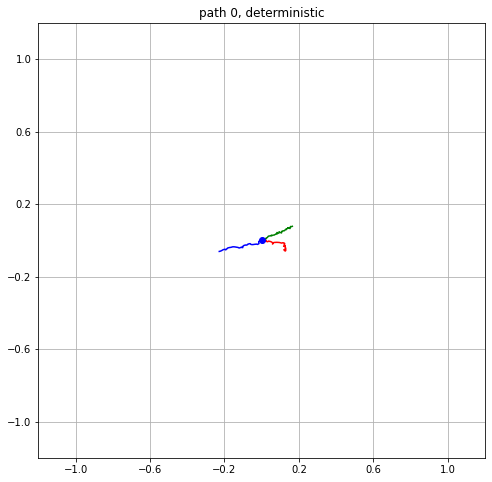

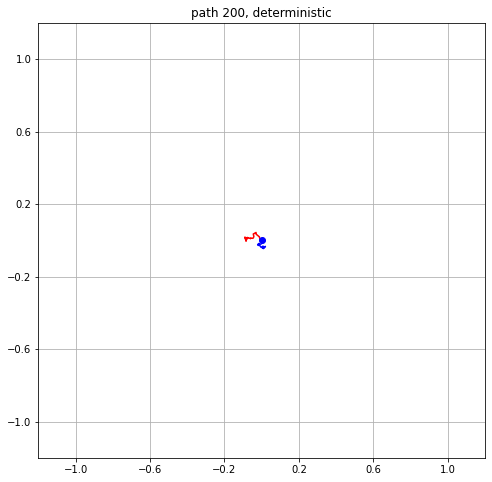

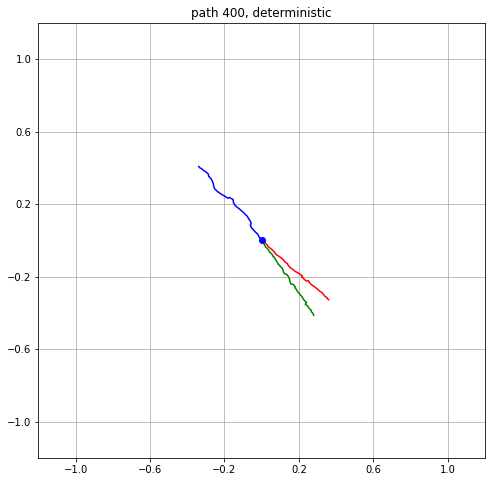

In [7]:
N = 0
multiplier = 200
amount = 3

for i in range(amount):
    n = N + multiplier * i

    x = eval_data[0][n]
    y = eval_data[2][n]

    prediction = m.predict_once(x)
    visualization.draw_path(x, y, predictions=[prediction], name=f"path {n}, deterministic")